In [16]:

import tweepy
import pandas as pd
import numpy as np
import re
import emoji
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

latitude = 30.08690216457294     # geographical centre of search
longitude = 31.330279552787587    # geographical centre of search
max_range = 150      # search range in kilometres


In [5]:
#Authenticate with credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [33]:
key_words = ['الاهلي']
limit = 2500

In [7]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [8]:
def TextClean(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'#[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'&[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'[?!.+,;$%&"]+', '', tweet)
    tweet = re.sub(r'rt[\s]+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\$', '', tweet)
    tweet = re.sub(r'rt+', '', tweet)
    tweet = re.sub(r'https?:?\/\/\S+', '', tweet)
    return tweet

def removeWeirdChars(text):
    weirdPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weirdPatterns.sub(r'', text)

def stopWordRmove(Tweet):
    ar_stop_list = open("Arabic Stopwords.txt",encoding="utf8")
    stop_words = ar_stop_list.read().split('\n')
    needed_words = []
    words =word_tokenize(Tweet)
    for w in words:
        if w not in (stop_words):
            needed_words.append(w)
    filtered_sentence = " ".join(needed_words)
    return filtered_sentence



In [9]:
!pip install pyarabic
import pyarabic.araby as araby
def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 24.9 MB/s 


In [10]:
! pip install Tashaphyne

from tashaphyne.stemming import ArabicLightStemmer
from nltk.stem.isri import ISRIStemmer
ArListem = ArabicLightStemmer()

def stem(text):
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ArListem.light_stem(w)
        cleaned.append(ArListem.get_root())
    return " ".join(cleaned)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 251 kB 15.6 MB/s 


In [13]:
def tweet_search(key_word):
    i = 0
    tweets_df = pd.DataFrame(columns=['Datetime', 'Tweet', 'Username', 'Retweets', 'Followers'])
    for tweet in tweepy.Cursor(api.search, q = key_word,geocode = "%f,%f,%dkm" % (latitude, longitude, max_range) ,count = 100, lang = 'ar', tweet_mode = 'extended').items():
        print('Tweets downloaded:', i, '/', limit, end = '\r')
        if tweet.user.followers_count > 100:
            tweets_df = tweets_df.append({'Datetime': tweet.created_at,
                                          'Tweet': tweet.full_text,
                                          'Username': tweet.user.screen_name,
                                          'Retweets': tweet.retweet_count,
                                          'Followers': tweet.user.followers_count}, ignore_index = True)
            i += 1
        if i >= limit:
            break
        else:
            pass
        
    tweets_df['Datetime'] = pd.to_datetime(tweets_df['Datetime'], format = '%Y.%m.%d %H:%M:%S')
    tweets_df.drop_duplicates(subset = ['Tweet'], inplace = True)
    tweets_df['CleanTweet'] = tweets_df['Tweet'].apply(TextClean)
    tweets_df['CleanTweet'] = tweets_df['CleanTweet'].apply(normalizeArabic)
    #tweets_df['CleanTweet'] = tweets_df['CleanTweet'].apply(stem)
    tweets_df['CleanTweet'] = tweets_df['CleanTweet'].apply(stopWordRmove)
    tweet_tokenizer = TweetTokenizer()
    tweets_df['CleanTweet'] = tweets_df['CleanTweet'].apply(tweet_tokenizer.tokenize)
    tweets_df['CleanTweet'] = [', '.join(map(str, token)) for token in tweets_df['CleanTweet']]
    tweets_df['CleanTweet'] = tweets_df['CleanTweet'].apply(removeWeirdChars)
    return tweets_df

In [37]:
tweets_df = pd.DataFrame()
for x in key_words:
    df =tweet_search(x)
    tweets_df=tweets_df.append(df, ignore_index=True)
tweets_df

,Datetime,Tweet,Username,Retweets,Followers,CleanTweet
0,2022-05-25 23:01:06,يارب الاهلى بطل دورى ابطال افريقيا ٢٠٢٢ 🙏🙏🙏\nي...,sarahaa11am,1,14469,"يارب, الاهلي, بطل, دوري, ابطال, افريقيا, , , ي..."
1,2022-05-25 22:57:46,@Imanramadan1215 والست كيمي حطالنا صورتها بعد ...,MagdySoliman1,1,1558,"والست, كيمي, حطالنا, صورتها, الكيمتريل, شيط, ش..."
2,2022-05-25 22:55:48,نفسي يوم النهائي انام مبسوطة الواحد مش عايز ير...,MohiNoura,0,330,"نفسي, النهاءي, انام, مبسوطه, الواحد, عايز, يرو..."
3,2022-05-25 22:53:30,اكرامي الشحات مع مهيب \nمش قادر يتكلم عن بطاطس...,abakry66,0,401,"اكرامي, الشحات, مهيب, قادر, يتكلم, بطاطس, ومهز..."
4,2022-05-25 22:52:02,بكلم مهندس صديقى بقوله \nمتعرفش اللى حصل ؟\nقا...,givara171972001,1,8143,"بكلم, مهندس, صديقي, بقوله, متعرفش, حصل, ؟, قال..."
...,...,...,...,...,...,...
2484,2022-05-23 18:54:23,#الأهلي: لا نعلم شيئًا عن «رحلات الجارحي» .. و...,AlMasrySports,2,881619,"#, الاهلي, :, نعلم, شيءا, «, رحلات, الجارحي, »..."
2485,2022-05-23 18:54:23,@7mni_n على خطى خبراني الاهلي,almask3232,0,413,"خطي, خبراني, الاهلي"
2486,2022-05-23 18:52:09,🔔الجيش الروسي يدخل أسلحة ليـزر جديدة في حرب او...,SummaryEgypt,1,7174,", الجيش, الروسي, يدخل, اسلحه, ليزر, جديده, حرب..."
2487,2022-05-23 18:52:00,@ahmedrezq__ كدا كدا محسومه لمدريد \nربنا يستر...,A7md7sn74,0,591,"كدا, كدا, محسومه, لمدريد, ربنا, يستر, الاهلي"


In [38]:
all_tweets = ' '.join(tweet for tweet in tweets_df['CleanTweet'])
all_tweets

"يارب, الاهلي, بطل, دوري, ابطال, افريقيا, , , يارب, الحداشر, رب, , ,  والست, كيمي, حطالنا, صورتها, الكيمتريل, شيط, شعرها, وبقت, اوكرانيه, , , بتقولك, البنك, الاهلي, مرهون, الامارات, وشكلها, بتاخد, كيميتريل, الريق, هبيده, عبيطه, ,  نفسي, النهاءي, انام, مبسوطه, الواحد, عايز, يروح, متنكد, للامتحان, صباحيه, التاني, اتمني, الاهلي, ياخد, منهم, البطوله, زي, خادوها, مننا, صعب, اني, اشوف, فرقه, تاخد, مننا, البطوله, للمره, التانيه اكرامي, الشحات, مهيب, قادر, يتكلم, بطاطس, ومهزوم, الشاشه, ورفض, التعليق, انتقاله, للزمالك, وصديقه, بيبو, الملايين, بيحارب, الدنيا, كلها, لوحده, علشان, الاهلي, يقعش, شء, مقرف, والله بكلم, مهندس, صديقي, بقوله, متعرفش, حصل, ؟, قالي, ايه, ؟, قولت, #, تيران_وصنافير, زالت, مصريه, يتم, تسليمها, دوليا, للسعوديه, قالي, عم, انا, فاضي, لتيران, بتاعتك, انا, بدور, معلومه, التشكيله, هيلعب, #, الاهلي, ابتسمت, وقولت, سعده, ويا, هناه, محتل, يحتل, مصر المره, جايه, الاهلي, بقي, ,  افريقيا, #, الاهلي برغم, التشكيله, غريبه, الاطوار, بدا, بيها, الاهلي, الماتش, نزول, افشه, محوري, قلب, المواز

In [39]:
! pip install arabic_reshaper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
! pip install python-bidi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
all_tweets = arabic_reshaper.reshape(all_tweets)
all_tweets = get_display(all_tweets)
WordCloud = WordCloud(width = 800, height = 400, random_state = 21, max_font_size = 100, collocations = False).generate(all_tweets)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

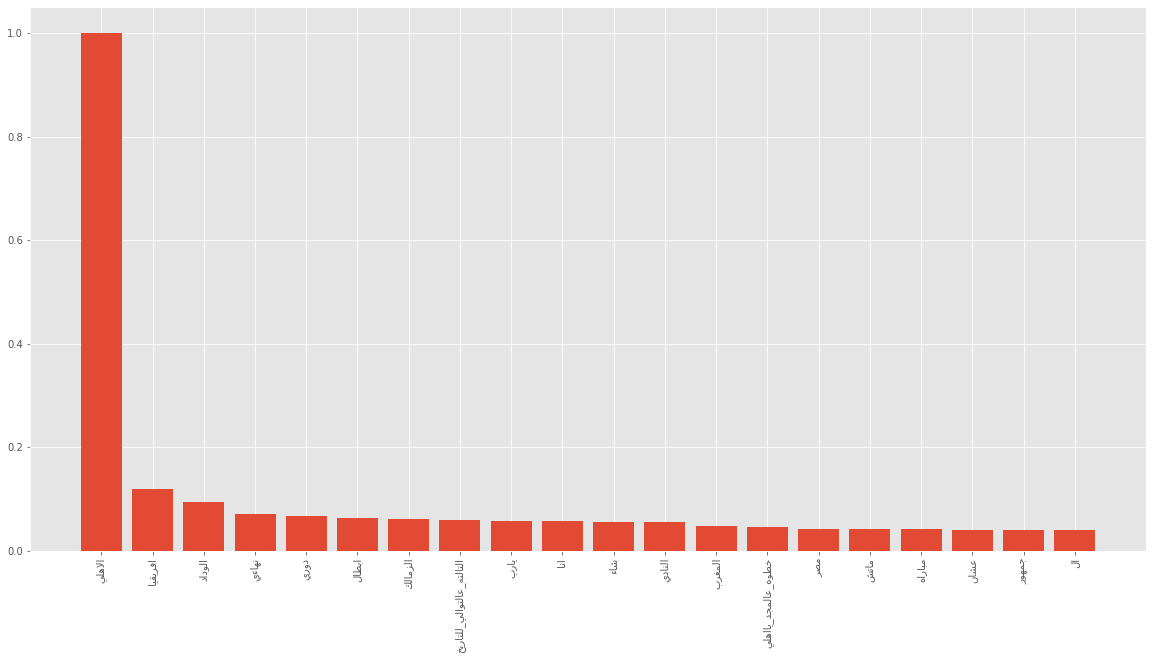

In [41]:
plt.style.use('ggplot')
word_frequency = pd.DataFrame.from_dict(data = WordCloud.words_, orient = 'index')
word_frequency = word_frequency.head(20)
plt.figure(figsize = (20, 10))
plt.bar(word_frequency.index, word_frequency[0])
plt.xticks(rotation = 90)

In [42]:
tweets_df['CleanTweet'] = tweets_df['CleanTweet'].apply(stem)
tweets_df['CleanTweet'] = [''.join(map(str, token)) for token in tweets_df['CleanTweet']]
tweets_df

,Datetime,Tweet,Username,Retweets,Followers,CleanTweet
0,2022-05-25 23:01:06,يارب الاهلى بطل دورى ابطال افريقيا ٢٠٢٢ 🙏🙏🙏\nي...,sarahaa11am,1,14469,ورب وهل بطل دور بطل فرق ورب حدشر رب
1,2022-05-25 22:57:46,@Imanramadan1215 والست كيمي حطالنا صورتها بعد ...,MagdySoliman1,1,1558,ولس كيم حطل صور لكمترل شيط شعر بقت كرن قول لبن...
2,2022-05-25 22:55:48,نفسي يوم النهائي انام مبسوطة الواحد مش عايز ير...,MohiNoura,0,330,نفس نهء ونم بسط لحد عوز روح نكد متح صبح ولت وت...
3,2022-05-25 22:53:30,اكرامي الشحات مع مهيب \nمش قادر يتكلم عن بطاطس...,abakry66,0,401,كرم شحو هيب قدر كلم ططس هزم شوش رفض علق نتقل ز...
4,2022-05-25 22:52:02,بكلم مهندس صديقى بقوله \nمتعرفش اللى حصل ؟\nقا...,givara171972001,1,8143,كلم هندس صدق بقل عرفش حصل ؟ قلو ويه ؟ قلت ترن_...
...,...,...,...,...,...,...
2484,2022-05-23 18:54:23,#الأهلي: لا نعلم شيئًا عن «رحلات الجارحي» .. و...,AlMasrySports,2,881619,وهل علم شيء « رحل جرح » سمر دعم سفر جمهر
2485,2022-05-23 18:54:23,@7mni_n على خطى خبراني الاهلي,almask3232,0,413,خطط خبر وهل
2486,2022-05-23 18:52:09,🔔الجيش الروسي يدخل أسلحة ليـزر جديدة في حرب او...,SummaryEgypt,1,7174,جيش رسو دخل سلح زرر جدد حرب كرن زلنسك يدع سلم ...
2487,2022-05-23 18:52:00,@ahmedrezq__ كدا كدا محسومه لمدريد \nربنا يستر...,A7md7sn74,0,591,كدو كدو حسم درد ربن ستر وهل
